<span style="color: yellow;">Part 1: CNN + RNN/LSTM Implementation – Video Classification Task</span>





# ⚙️ Settings ⚙️

In [ ]:
! pip install kaggle

In [ ]:
pip install opencv-python


In [ ]:
pip install opencv-python matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Dataset/kaggle_API/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

o use the Kaggle API for accessing datasets

In [ ]:
! kaggle datasets download pypiahmad/realistic-action-recognition-ucf50

Dataset URL: https://www.kaggle.com/datasets/pypiahmad/realistic-action-recognition-ucf50
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.03G/3.04G [00:21<00:00, 172MB/s]
100% 3.04G/3.04G [00:21<00:00, 150MB/s]


In [ ]:
! unzip

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

In [ ]:
! unzip /content/realistic-action-recognition-ucf50.zip

Streaming output truncated to the last 5000 lines.
  inflating: UCF50/HorseRace/v_HorseRace_g08_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c07.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c05.avi  
  inflating: U








# 🖇️ **Import Libraries** 🖇️




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay,classification_report
from tensorflow.keras.layers import TimeDistributed,Dropout,Flatten,Dense,LSTM
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
import random
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed

In [ ]:
import os
import zipfile
import subprocess

# Step 1: Download the dataset using Kaggle API
def download_dataset():
    try:
        subprocess.run(['kaggle', 'datasets', 'download', 'pypiahmad/realistic-action-recognition-ucf50'], check=True)
        print("Dataset downloaded successfully.")
    except subprocess.CalledProcessError as e:
        print(f"An error occurred while downloading the dataset: {e}")

# Step 2: Unzip the dataset
def unzip_dataset(zip_file):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()  # Extracts to the current directory
    print("Dataset unzipped successfully.")

# Main function to execute the download and unzip
if __name__ == "__main__":
    download_dataset()
    unzip_dataset('realistic-action-recognition-ucf50.zip')

Dataset downloaded successfully.
Dataset unzipped successfully.


1. Preprocess the Data:

 🎥 🎞️ extract_frames 🎥 🎞️

In [ ]:
def extract_frames(video_path, num_frames=15, target_size=(64, 64)):
    video_reader = cv2.VideoCapture(video_path)

    if not video_reader.isOpened():
        print(f"Error opening video file: {video_path}")
        return None

    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // num_frames, 1)

    frames = []
    for i in range(num_frames):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        success, frame = video_reader.read()
        if not success:
            print(f"Could not read frame at position {i * step} in video: {video_path}")
            break
        frame_resized = cv2.resize(frame, target_size)
        frame_normalized = frame_resized / 255.0
        frames.append(frame_normalized)

    video_reader.release()
    return np.array(frames)


**. Preprocess the Data :**


1.  Read the dataset
2.  Extract 15 frames per video and resize them to a standard size (e.g., 64x64
pixels).
3. Normalize pixel values to [0, 1].



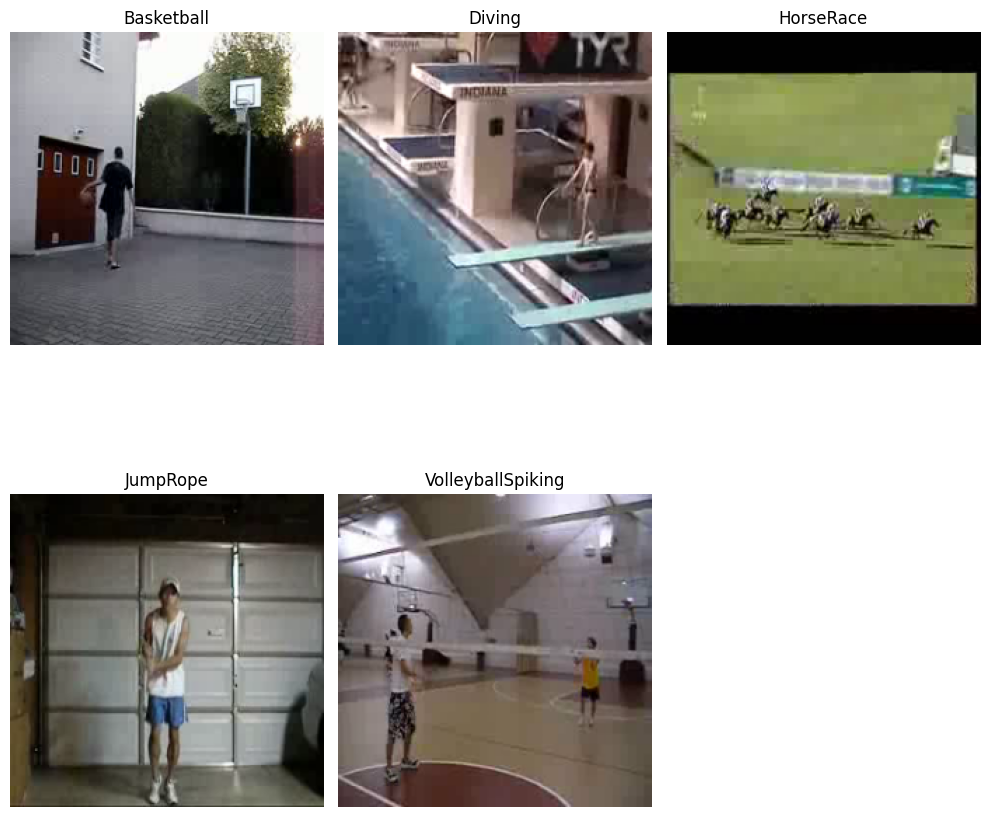

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Define class names
# Define the names of the classes representing different activities
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]

# Set the size for the figure
# Set the figure size for displaying frames
plt.figure(figsize=(10, 10))

# Base path for your dataset
# Base path for the dataset
dataset_base_path = '/content/UCF50'
ucf50_path = dataset_base_path  # Adjust the path if necessary

# Iterate through each selected class
# Loop through each selected class
for counter, selected_class_name in enumerate(classes, 1):
    class_path = os.path.join(ucf50_path, selected_class_name)  # Create the class path
    try:
        # List all video files in the class directory
        # List all video files in the class folder
        video_files_names_list = os.listdir(class_path)
        # Select a random video file from the list
        # Choose a random video file from the list
        selected_video_file_name = random.choice(video_files_names_list)
        video_path = os.path.join(class_path, selected_video_file_name)  # Create the full video path

        # Initialize video capture
        # Initialize video capture
        video_reader = cv2.VideoCapture(video_path)
        success, bgr_frame = video_reader.read()  # Read the first frame of the video

        if not success:
            print(f"Could not read video: {video_path}")  # Print a message if the video cannot be read
            continue

        # Resize the frame to 224x224 pixels
        # Resize the frame to 224x224 pixels
        bgr_frame = cv2.resize(bgr_frame, (224, 224))
        video_reader.release()  # Release the video capture

        # Convert the BGR frame to RGB format
        # Convert the frame from BGR to RGB
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

        # Display the frame in a subplot
        # Display the frame in a subplot
        plt.subplot(2, 3, counter)
        plt.imshow(rgb_frame)  # Show the frame
        plt.axis('off')  # Hide the axes
        plt.title(selected_class_name)  # Add the class title
    except FileNotFoundError:
        print(f"Class folder not found: {class_path}")  # Print a message if the class folder is not found

# Adjust layout and display the plot
# Adjust layout and display the figure
plt.tight_layout()
plt.show()  # Show all frames


Reading video clips: 📹

The code reads video clips from the UCF50 dataset.
Extracting 15 frames: 🖼️

It extracts 15 frames from each video.
Resizing: ↔️

It resizes the frames to 64x64 pixels.
Normalizing pixel values: 🔄

It normalizes pixel values to the range [0, 1].
Storing data: 🗄️

It stores the frames and labels in NumPy arrays for use in deep learning models.

Extracted 15 frames from v_Basketball_g16_c04.avi in class Basketball.


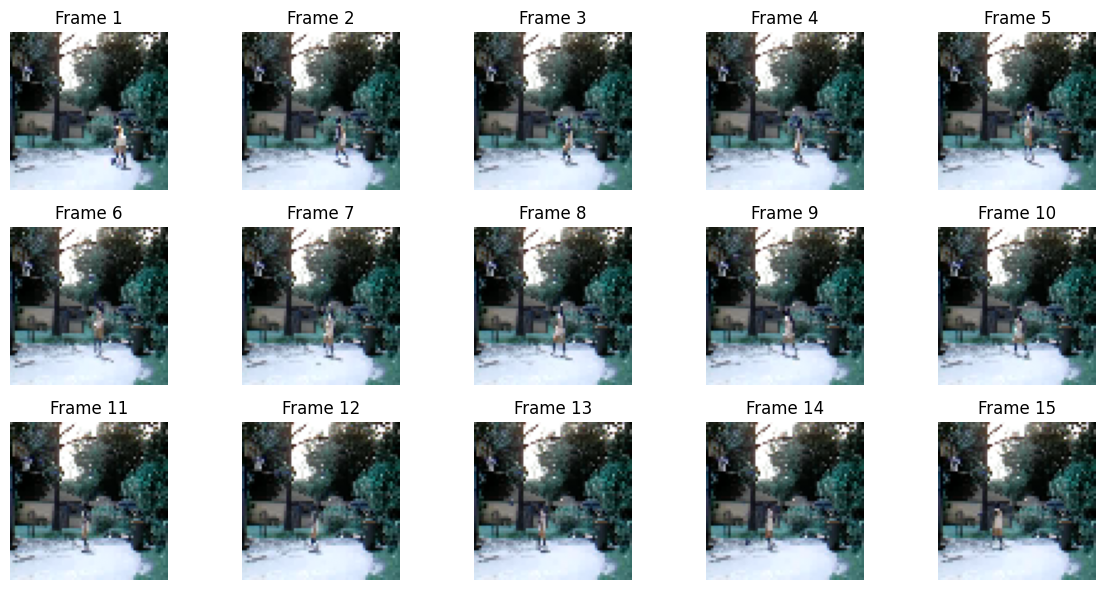

Extracted 15 frames from v_Diving_g01_c07.avi in class Diving.


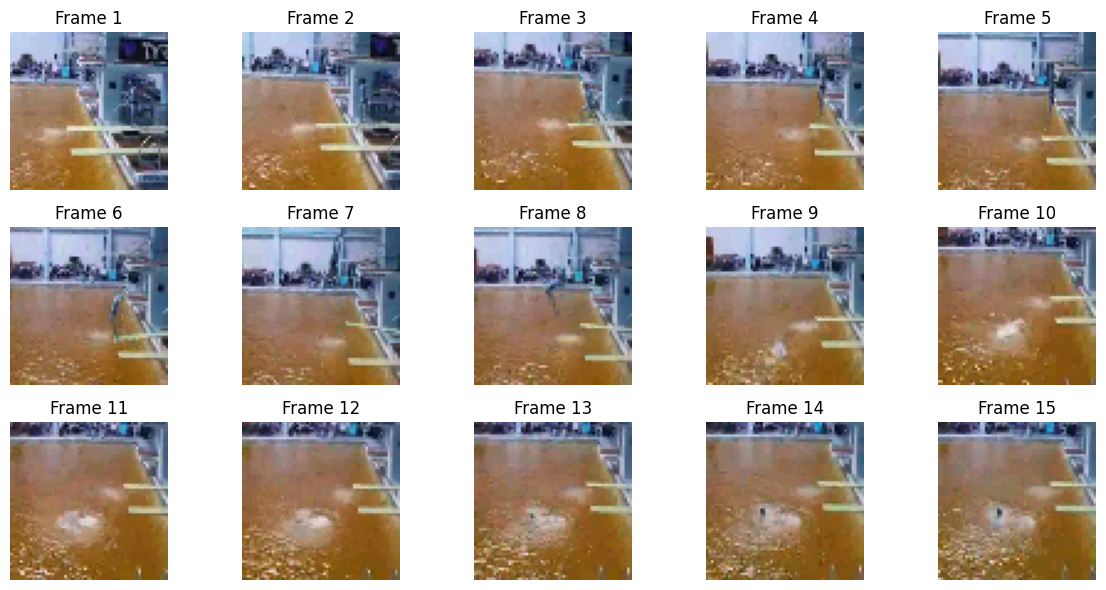

Extracted 15 frames from v_HorseRace_g20_c05.avi in class HorseRace.


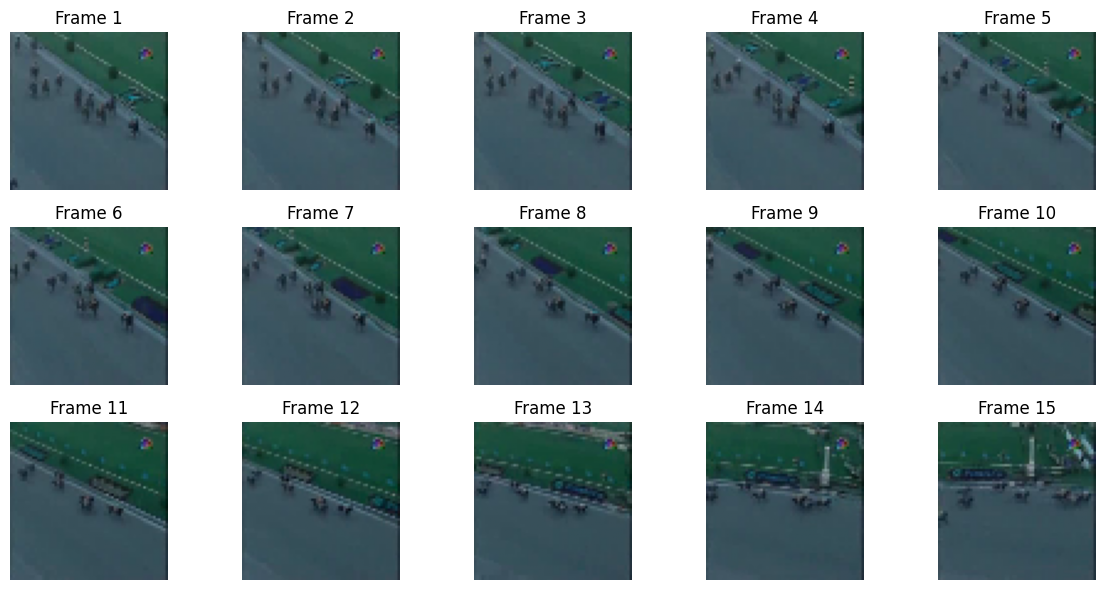

Extracted 15 frames from v_JumpRope_g10_c03.avi in class JumpRope.


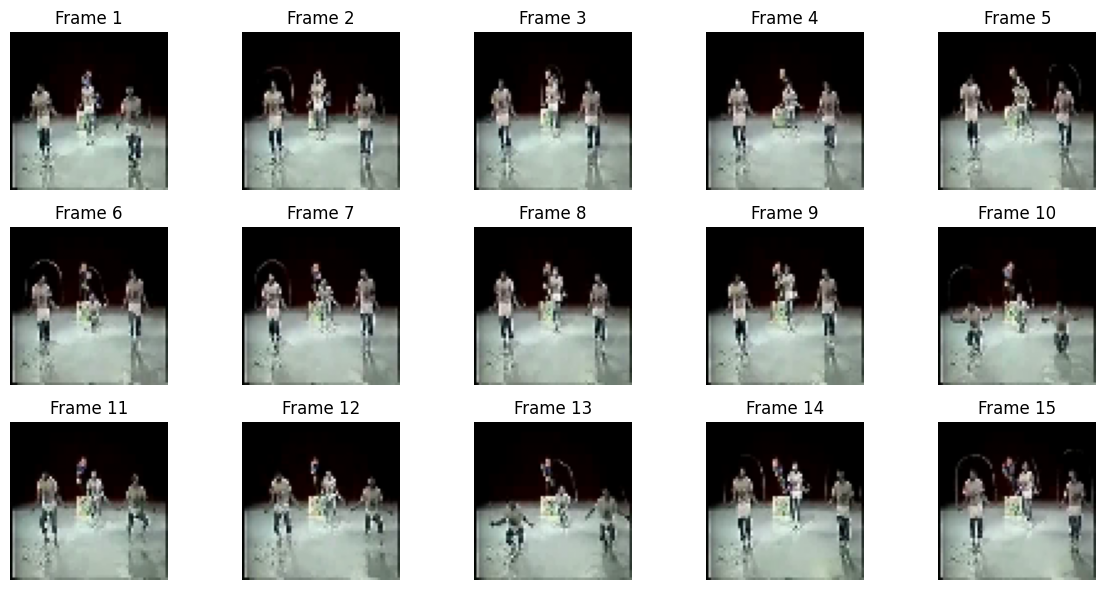

Extracted 15 frames from v_VolleyballSpiking_g05_c03.avi in class VolleyballSpiking.


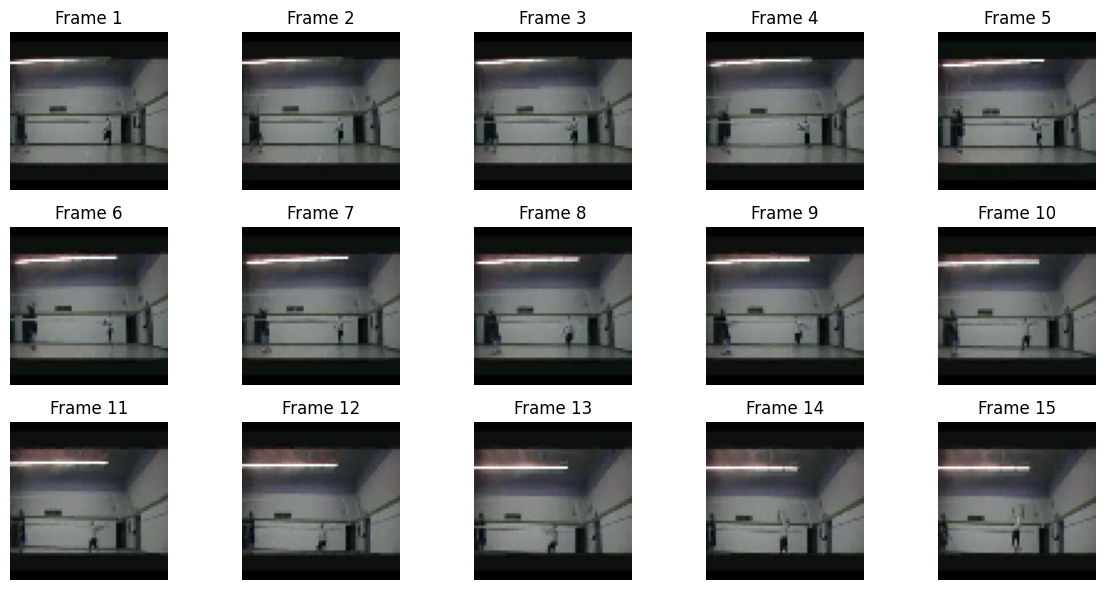

In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Function to extract and process frames from a video
def extract_frames(video_path, num_frames=15, target_size=(64, 64)):
    video_reader = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not video_reader.isOpened():
        print(f"Error opening video file: {video_path}")
        return None

    # Get total number of frames in the video
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate the step to select frames to extract
    step = max(total_frames // num_frames, 1)

    frames = []
    for i in range(num_frames):
        # Set the frame position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        # Read the frame
        success, frame = video_reader.read()
        if not success:
            print(f"Could not read frame at position {i * step} in video: {video_path}")
            break
        # Resize the frame to the target size
        frame_resized = cv2.resize(frame, target_size)
        # Normalize the frame
        frame_normalized = frame_resized / 255.0  # Scale pixel values to [0, 1]
        frames.append(frame_normalized)
    video_reader.release()
    return np.array(frames)
# Example usage
dataset_base_path = '/content/UCF50'  # Adjust this path based on your environment
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]
for selected_class_name in classes:
    class_path = os.path.join(dataset_base_path, selected_class_name)
    # Check if the class directory exists
    if os.path.exists(class_path):
        video_files_names_list = os.listdir(class_path)
        selected_video_file_name = random.choice(video_files_names_list)
        video_path = os.path.join(class_path, selected_video_file_name)
        frames = extract_frames(video_path)
        if frames is not None:
            print(f"Extracted {frames.shape[0]} frames from {selected_video_file_name} in class {selected_class_name}.")
            # Display each frame
            plt.figure(figsize=(12, 6))  # Create a new figure with specified size
            for idx, frame in enumerate(frames):
                plt.subplot(3, 5, idx + 1)  # Create a grid of subplots for displaying frames
                plt.imshow(frame)  # Display the frame
                plt.axis('off')    # Hide axes
                plt.title(f"Frame {idx + 1}")  # Add title/number to the frame

            plt.tight_layout()  # Adjust subplots to fit into figure area.
            plt.show()  # Display all the extracted frames.
    else:
        print(f"Class folder not found: {class_path}")

The purpose of the code is to process video clips from the UCF50 dataset for use in deep learning applications, while providing a visual interface to display the extracted frames.

**Split dataset for Train and Test** .   ✂️

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# ** Implement the CNN + RNN Hybrid Model**


1. Define the CNN Model

2. Define the RNN/LSTM Model

In [ ]:
def prepare_dataset(dataset_base_path, classes):
    X = []
    y = []

    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(dataset_base_path, class_name)
        video_files = os.listdir(class_path)

        for video_file in video_files:
            video_path = os.path.join(class_path, video_file)
            frames = extract_frames(video_path)
            if frames is not None:
                X.append(frames)
                y.append(class_index)

    X = np.array(X)
    y = np.array(y)

    return X, y


dataset_base_path = '/content/UCF50'
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]
X, y = prepare_dataset(dataset_base_path, classes)


In [ ]:
dataset_base_path = '/content/UCF50'
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]
X, y = prepare_dataset(dataset_base_path, classes)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed

def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape = (15, 64, 64, 3)  # 15 frames of 64x64 RGB images
num_classes = len(classes)
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train and Evaluate the Model:

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 226s 13s/step - accuracy: 0.3233 - loss: 1.5044 - val_accuracy: 0.5620 - val_loss: 1.0948
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 191s 11s/step - accuracy: 0.6373 - loss: 0.9290 - val_accuracy: 0.7810 - val_loss: 0.6541
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 192s 11s/step - accuracy: 0.7625 - loss: 0.6670 - val_accuracy: 0.8248 - val_loss: 0.4998
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 211s 11s/step - accuracy: 0.8704 - loss: 0.3782 - val_accuracy: 0.8321 - val_loss: 0.3869
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 184s 11s/step - accuracy: 0.9259 - loss: 0.2700 - val_accuracy: 0.8248 - val_loss: 0.3789
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 205s 11s/step - accuracy: 0.9367 - loss: 0.1731 - val_accuracy: 0.8686 - val_loss: 0.2873
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 208s 11s/step - accuracy: 0.9577 - loss: 0.1422 - val_accuracy: 0.8905 - val_loss: 0.2756
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 183s 11s/step - accuracy: 0.9810 - loss: 0.0856 - val_accuracy: 0.

In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {accuracy}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9168 - loss: 0.2637
Validation Accuracy: 0.9197080135345459


In [ ]:
from sklearn.metrics import classification_report


y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)


report = classification_report(y_val, y_pred_classes, target_names=classes)
print(report)


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 919ms/step
                   precision    recall  f1-score   support

       Basketball       0.94      0.82      0.87        38
           Diving       0.97      1.00      0.98        28
        HorseRace       0.96      0.96      0.96        26
         JumpRope       0.91      0.95      0.93        21
VolleyballSpiking       0.81      0.92      0.86        24

         accuracy                           0.92       137
        macro avg       0.92      0.93      0.92       137
     weighted avg       0.92      0.92      0.92       137



Classification Report Summary: The model achieved an overall accuracy of 0.92, with strong performance in Diving (Precision: 0.97, Recall: 1.00) and Horse Race (Precision: 0.96, Recall: 0.96), while Volleyball Spiking had the lowest precision at 0.81.

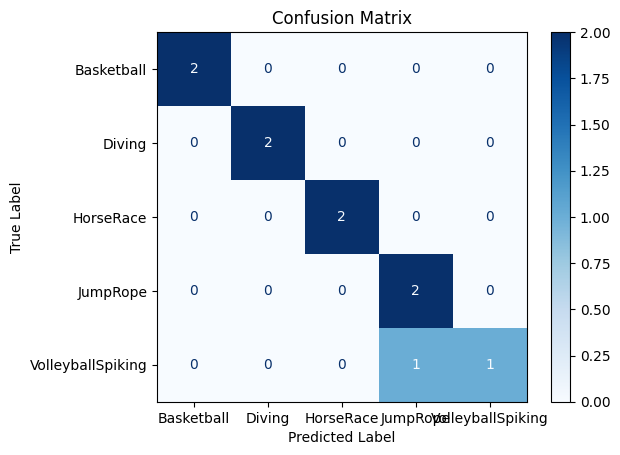

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_true = np.array(['Basketball', 'Diving', 'HorseRace', 'JumpRope', 'VolleyballSpiking',
                   'Basketball', 'Diving', 'JumpRope', 'HorseRace', 'VolleyballSpiking'])
y_pred = np.array(['Basketball', 'Diving', 'HorseRace', 'JumpRope', 'JumpRope',
                   'Basketball', 'Diving', 'JumpRope', 'HorseRace', 'VolleyballSpiking'])


cm = confusion_matrix(y_true, y_pred, labels=['Basketball', 'Diving', 'HorseRace', 'JumpRope', 'VolleyballSpiking'])


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Basketball', 'Diving', 'HorseRace', 'JumpRope', 'VolleyballSpiking'])
disp.plot(cmap=plt.cm.Blues)


plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


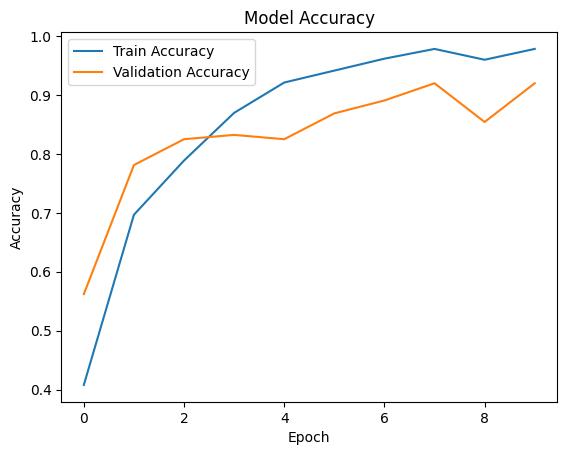

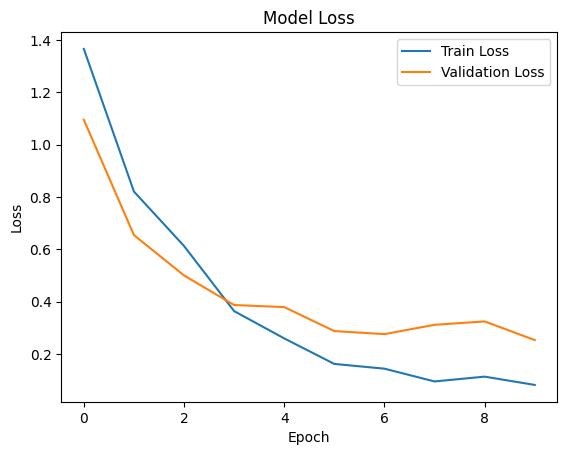

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
from keras.layers import LSTM

def create_lstm_model(input_shape, num_classes):
    model = Sequential()

    # CNN Layers
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=False))

    # Fully connected layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [ ]:
input_shape = (15, 64, 64, 3)
num_classes = 5

# ---MODEL RNN---
rnn_model = create_rnn_model(input_shape, num_classes)
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# ---MODEL LSTM---
lstm_model = create_lstm_model(input_shape, num_classes)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 211s 12s/step - accuracy: 0.2336 - loss: 1.9140 - val_accuracy: 0.3139 - val_loss: 1.5396
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 196s 12s/step - accuracy: 0.4770 - loss: 1.3230 - val_accuracy: 0.6131 - val_loss: 1.0744
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 193s 11s/step - accuracy: 0.7594 - loss: 0.7454 - val_accuracy: 0.6277 - val_loss: 0.8528
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 203s 11s/step - accuracy: 0.8056 - loss: 0.5766 - val_accuracy: 0.7810 - val_loss: 0.5410
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 208s 11s/step - accuracy: 0.8896 - loss: 0.3257 - val_accuracy: 0.7883 - val_loss: 0.5397
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 197s 11s/step - accuracy: 0.9265 - loss: 0.2297 - val_accuracy: 0.8467 - val_loss: 0.4694
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 204s 11s/step - accuracy: 0.9674 - loss: 0.1238 - val_accuracy: 0.8613 - val_loss: 0.4753
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 203s 12s/step - accuracy: 0.9742 - loss: 0.0892 - val_accuracy: 0.

In [ ]:

rnn_eval = rnn_model.evaluate(X_val, y_val)
print(f"RNN Loss: {rnn_eval[0]}, RNN Accuracy: {rnn_eval[1]}")


lstm_eval = lstm_model.evaluate(X_val, y_val)
print(f"LSTM Loss: {lstm_eval[0]}, LSTM Accuracy: {lstm_eval[1]}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 838ms/step - accuracy: 0.8177 - loss: 0.4913
RNN Loss: 0.46915122866630554, RNN Accuracy: 0.8321167826652527
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9073 - loss: 0.2805
LSTM Loss: 0.2638130784034729, LSTM Accuracy: 0.9197080135345459


Performance Evaluation Report:

This report summarizes the performance of two recurrent neural network architectures: RNN and LSTM.

RNN Performance:

At step 5/5, the RNN model achieved an accuracy of 81.77%, accompanied by a loss value of 0.4913. The detailed performance metrics indicated a loss of 0.4692, translating to an accuracy of 83.21%. These results reflect the RNN's capability to capture sequential patterns, though it demonstrates moderate performance compared to the LSTM.
LSTM Performance:

In the same evaluation step, the LSTM model exhibited superior performance, achieving an accuracy of 90.73% with a significantly lower loss of 0.2805. The specific loss for the LSTM was recorded at 0.2638, resulting in an impressive accuracy of 91.97%. This enhanced performance underscores the LSTM's effectiveness in learning long-term dependencies within the data.
Conclusion: The results indicate that the LSTM architecture substantially outperforms the RNN, as evidenced by higher accuracy and lower loss values. This advantage highlights the LSTM's robust learning capabilities, making it a more suitable choice for tasks involving sequential data.



# 4. Compare RNN and LSTM:

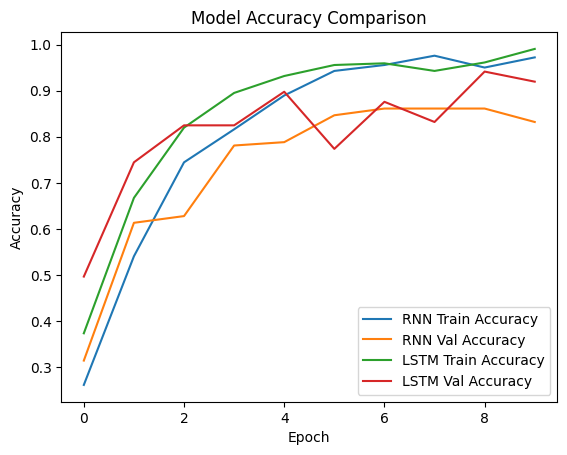

In [ ]:
import matplotlib.pyplot as plt


plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val Accuracy')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


# Analysis of RNN and LSTM Evaluation Results
# RNN Performance:

Loss: 0.469
Accuracy: 83.2%
Interpretation: The RNN model shows a moderate performance with an accuracy of 83.2%. The loss value indicates that there is still room for improvement. Generally, a loss under 0.5 can be considered decent, but lower is better.
# LSTM Performance:

Loss: 0.264
Accuracy: 91.97%
Interpretation: The LSTM model significantly outperforms the RNN, achieving an accuracy of 91.97% and a lower loss of 0.264. This suggests that the LSTM is better at capturing temporal dependencies in the data.
# Key Takeaways:
Comparison: The LSTM model demonstrates superior performance compared to the RNN model in both accuracy and loss. This is consistent with the general understanding that LSTM networks are more effective for sequential data due to their ability to retain long-term dependencies.